[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/convergence_analysis.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/convergence_analysis.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/convergence_analysis.ipynb)

### Paweł Magnuszewski MSc project

### arithmetic Asian call valuation - MPDATA convergence analysis

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [2]:
import os
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot
from PyMPDATA import Options

from PyMPDATA_examples.Magnuszewski_et_al_2025.asian_option import AsianArithmetic, Settings
from PyMPDATA_examples.Magnuszewski_et_al_2025.common import OPTIONS
from PyMPDATA_examples.Magnuszewski_et_al_2025.monte_carlo import BSModel, FixedStrikeArithmeticAsianOption

In [74]:
mc_n_paths = 10000 if 'CI' not in os.environ else 10000
mc_seed = 42
mc_path_points = 1000

scales = (1, 2, 4, 8)

base_resolution = {
    'nt': 128,
    'nx': 9,
    'ny': 9,
}

SETTINGS = Settings(
    T=1,
    K=100,
    r=.05,
    sgma=.4,
    S_max=200,
    S_min=50,
)
variant = "call"

In [75]:
def asian_mc_at_spot(spot):
    mc_model = BSModel(
        T=SETTINGS.T,
        sigma=SETTINGS.sgma,
        r=SETTINGS.r,
        M=mc_path_points,
        S0=spot,
        seed=mc_seed
    )
    arithmetic_option = FixedStrikeArithmeticAsianOption(1, 100, variant, mc_model, mc_n_paths)
    return arithmetic_option.price_by_mc()

In [76]:
def calculate_l2_norm(array1, array2, ny, nt):
    nx = len(array1)
    return np.sqrt(np.sum((array1 - array2) ** 2) / (nx * ny * nt))

In [77]:
biggest_scale = max(scales)
dummy_simulation = AsianArithmetic(
    SETTINGS,
    **{k: v * biggest_scale + 1 for k, v in base_resolution.items()},
    options=OPTIONS["MPDATA (2 it.)"],
    variant=variant
)
most_discretized_domain = dummy_simulation.S.copy()

max_mc_domain = np.zeros_like(most_discretized_domain)
for idx, spot in enumerate(most_discretized_domain):
    max_mc_domain[idx] = asian_mc_at_spot(spot)

In [78]:
l2_errors = {k: [] for k in OPTIONS.keys()}
simulation = {}
simulation_price = {}
for scale in scales:
    resolution_scaled = {k: v * scale + 1 for k, v in base_resolution.items()}
    for key in OPTIONS:
        simulation[key] = AsianArithmetic(SETTINGS, **resolution_scaled, options=OPTIONS[key], variant=variant)
        simulation[key].step(simulation[key].nt)
        simulation_price[key] = simulation[key].solver.advectee.get()[:, 0]   
    arithmetic_by_mc = np.interp(simulation[key].S, most_discretized_domain, max_mc_domain)
    for key in OPTIONS:
        l2_errors[key].append(calculate_l2_norm(simulation_price[key], arithmetic_by_mc, simulation[key].ny, simulation[key].nt))

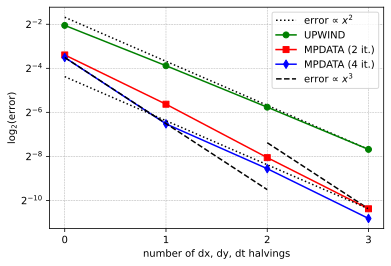

In [88]:
divisions = [np.log2(scale) for scale in scales]
theory_upwind = [l2_errors["UPWIND"][-1] / (scale ** -2) for scale in reversed(scales)]
theory_mpdata_2it_t2 = [l2_errors["MPDATA (2 it.)"][-1] / (scale ** -2) for scale in reversed(scales)]
theory_mpdata_2it_t3 = [l2_errors["MPDATA (2 it.)"][-1] / (scale ** -3) for scale in reversed(scales[:2])]
theory_mpdata_4it_t3 = [l2_errors["MPDATA (4 it.)"][0] / (scale ** 3) for scale in scales[:3]]

fig, ax = pyplot.subplots(figsize=(6, 4))
ax.set_xlabel("number of dx, dy, dt halvings")
ax.set_xticks(divisions)
ax.set_ylabel('log$_2$(error)')
ax.set_yscale('log', base=2)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.plot(divisions, theory_upwind, linestyle=':', color='k', label='error ∝ $x^2$')
ax.plot(divisions, l2_errors["UPWIND"], marker='o', linestyle='-', color='g', label='UPWIND')
ax.plot(divisions[-len(theory_mpdata_2it_t3):], theory_mpdata_2it_t3, linestyle='--', color='k')
ax.plot(divisions, l2_errors["MPDATA (2 it.)"], marker='s', linestyle='-', color='r', label='MPDATA (2 it.)')
ax.plot(divisions, l2_errors["MPDATA (4 it.)"], marker='d', linestyle='-', color='b', label='MPDATA (4 it.)')
ax.plot(divisions, theory_mpdata_2it_t2, linestyle=':', color='k')
ax.plot(divisions[:len(theory_mpdata_4it_t3)], theory_mpdata_4it_t3, linestyle='--', color='k', label='error ∝ $x^3$')
ax.legend()
show_plot("convergence_analysis.pdf")